In [1]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vEcoli/notebooks/mia_notebooks/metal_count_data/'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats
from sklearn.metrics import r2_score

# Set the default style
sns.set(style="darkgrid")

# LB Media Data

## Ground truth data from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/)

Media type: LB media

Bacterial species: I believe E. coli BW25113

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: need to confirm if this is the correct strain of E. coli


In [2]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data

,Condition,Below_LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log_concentration,Concentration_(M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Minimal,0,1,CR,122.171244,354.00,9.08603,1000.000000,-5.893951,1.276582e-06,1556.247155
8,Minimal,0,1,V,113.253635,354.00,9.08603,1000.000000,-6.120670,7.574077e-07,923.335846
9,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626


In [3]:
# LB media data from GT data: 
GT_lb_data = GT_data[9:]
GT_lb_df = pl.DataFrame(GT_lb_data[["Element","Atoms/cell"]])
GT_lb_df = GT_lb_df.with_columns(pl.col("Atoms/cell").log10().alias("$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))"))

# replace the element names with the column names for merging later:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_lb_df0 = GT_lb_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_lb_df = pl.DataFrame(GT_lb_df0[["Element", "$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))"]])
GT_lb_df0

Element,Atoms/cell,"$ {E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))"
str,f64,f64
"""Mo""",10797.032626,4.033304
"""Zn""",399640.415582,5.601669
"""Cu""",87576.66829,4.942388
"""Ni""",3240.269333,3.510581
"""Co""",443.558908,2.646951
"""Fe""",607143.184501,5.783291
"""Mn""",46743.626407,4.669722
"""Cr""",3414.351358,3.533308
"""V""",249.432594,2.396953


## Covert Lab Simulation Data 

Media type: rich media (pressuably LB)

Bacterial Species: E. coli MG1655

Units used in calculations: Bulk atoms/cell (atoms per cell)

QUESTIONS/ISSUES:
- did he accidently send me the wrong data for this?

In [4]:
# load in the Covert lab simulation data (manually put in since there is so few):
sim_elements = ["Zn", "Fe", "Ni", "Cu", "Mn", "Co", "Mo"]
sim_values = [357248.6491, 438271.9937, 1342.232233, 19116.19354, 70569.16543, 1191.478964, 3623.204996]

# create a data frame:
sim_df = pd.DataFrame({"Element": sim_elements, "atoms/cell": sim_values})
sim_df = pl.DataFrame(sim_df)
sim_df0 = sim_df.with_columns(pl.col("atoms/cell").log10().alias("$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"))
sim_df = pl.DataFrame(sim_df0[["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]])
sim_df0

Element,atoms/cell,$ {E. coli}$ MG1655 (Covert Lab Simulation Data)
str,f64,f64
"""Zn""",357248.6491,5.552971
"""Fe""",438271.9937,5.641744
"""Ni""",1342.232233,3.127828
"""Cu""",19116.19354,4.281401
"""Mn""",70569.16543,4.848615
"""Co""",1191.478964,3.076086
"""Mo""",3623.204996,3.559093


## LB media data from Huynh et al., 2022 fig 1c and 1d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 

Media type: LB media

Bacterial species: E. coli K-12 BW25113

Units used in calculations: Atoms/CFU

QUESTIONS/ISSUES: 
- double check that I did my web plot analyzer stuff right when I do it for the minimal media conditions

In [5]:
# load in LB media data from Huynh et al., 2022 fig 1c and d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
Huynh_2022 = pd.read_excel("Huynh_2022_F1CD_data.xlsx")

# convert data frames to polars data frames and rename the columns to be more descriptive: 
Huynh_2022 = pl.DataFrame(Huynh_2022[["Element","log10 LB (atoms/CFU)"]])
H_2022 = Huynh_2022.with_columns(pl.col("log10 LB (atoms/CFU)").alias("$\t{E. coli}$ K-12 BW25113 (Huynh et al., 2022)"))
H_2022

Element,log10 LB (atoms/CFU),"$ {E. coli}$ K-12 BW25113 (Huynh et al., 2022)"
str,f64,f64
"""Mn""",3.5727,3.5727
"""Fe""",5.79822,5.79822
"""Cu""",4.596439,4.596439
"""Zn""",4.534125,4.534125
"""V""",2.699801,2.699801
"""Cr""",4.230616,4.230616
"""Co""",1.976143,1.976143
"""Ni""",3.38171,3.38171


## LB media data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):

Media type: LB media

Bacterial species: I think E. coli strain BW25113 (derived from K-12 lineage)

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 
- not entirely sure about what strain is used in the specific graph here, but pretty sure it is BW25113? (the WT in the paper) 

In [6]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("Budhraja_2019_F1_data.xlsx")
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","raise to ten"]])

# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("raise to ten").log10().alias("LBM_Budhraja_log_APC"))
B_2019 = LBM_F1_2019_df.rename({"metal": "Element", "raise to ten": "atoms/cell", "LBM_Budhraja_log_APC": "$\t{E. coli}$ strain? (Budhraja et al., 2019)"});
B_2019

Element,atoms/cell,"$ {E. coli}$ strain? (Budhraja et al., 2019)"
str,f64,f64
"""Mo""",14677.992676,4.166667
"""Ni""",14065.272421,4.148148
"""Co""",3300.034791,3.518519
"""Fe""",2.0354e6,6.308642


## LB media data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11)

Media type: LB media

Bacterial species: E. coli MG1655

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [7]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("Umemura_2017_T112_data.xlsx")

# transform into a polars data frame and rename the columns:
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log10().alias("$\t{E. coli}$ MG1655 (Umemura et al., 2017)"))
U_2017 = LBM_T112_2017_df.rename({"Symbol": "Element", "E. coli\xa0MG1655 in LB": "atoms/cell"})
U_2017

Element,atoms/cell,"$ {E. coli}$ MG1655 (Umemura et al., 2017)"
str,f64,f64
"""Mg""",7.5e7,7.875061
"""P""",4.2e8,8.623249
"""S""",1.7e8,8.230449
"""K""",2.6e8,8.414973
"""Ca""",6.2e6,6.792392
…,…,…
"""Au""",0.25,-0.60206
"""Tl""",45.0,1.653213
"""Pb""",60.0,1.778151


## LB media data from Nies & Herzberg, 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123 / Kristen et al., 2011: https://journals.asm.org/doi/full/10.1128/jb.05293-11

Media type: LB media

Bacterial species: E. coli W3110 

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [8]:
# LB media data from Nies et al., 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123
Nies_2012 = pd.read_excel("Nies_2012_T1_data.xlsx")
Nies_2012 = pl.DataFrame(Nies_2012[["Element", "Atoms/cell"]])
N_2012 = Nies_2012.with_columns(pl.col("Atoms/cell").log10().alias("$\t{E. coli}$ W3110 (Nies & Herzberg, 2012)"))
N_2012

Element,Atoms/cell,"$ {E. coli}$ W3110 (Nies & Herzberg, 2012)"
str,f64,f64
"""Mg""",1.27e7,7.103804
"""Ca""",2.0500e6,6.311754
"""Fe""",290000.0,5.462398
"""Co""",4500.0,3.653213
"""Ni""",9700.0,3.986772
"""Zn""",114000.0,5.056905
"""Mn""",11700.0,4.068186
"""Mo""",3450.0,3.537819
"""Cu""",169000.0,5.227887


## Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23#F4):

Media type: LB media

Bacterial species: uropathogenic E. coli strain CFT073 (UPEC)

Units used in calculations: pg/10^6 CFU

QUESTIONS/ISSUES: 
- Did I do my conversion right? 

In [9]:
# LB media from Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23):
SH_F2A_2024 = pd.read_excel("Saenkham_2024_F2a_data.xlsx")
SH_F2A_2024 = pl.DataFrame(SH_F2A_2024)

# convert units to atoms/CFU:
# pg to g: 1 pg = 10^-12 g
SH_LBM_2024 = pl.DataFrame(SH_F2A_2024[["Element", "CFT073/pGEN (pg/10^6 CFU)"]])
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (pg/10^6 CFU)") * 10**(-12)).alias("CFT073/pGEN (g/10^6 CFU)"))

# g/10^6 CFU to g/CFU:
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (g/10^6 CFU)") / 10**6).alias("CFT073/pGEN (g/CFU)"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# g to atoms:
Cu_value = SH_LBM_2024.filter(pl.col("Element") == "Cu").select("CFT073/pGEN (g/CFU)").item()
Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = SH_LBM_2024.filter(pl.col("Element") == "Fe").select("CFT073/pGEN (g/CFU)").item()
Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = SH_LBM_2024.filter(pl.col("Element") == "Mn").select("CFT073/pGEN (g/CFU)").item()
Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = SH_LBM_2024.filter(pl.col("Element") == "Zn").select("CFT073/pGEN (g/CFU)").item()
Zn_value = (Zn_value / mm_Zn) * Avogadro

# create new data frame: 
values = [Cu_value, Fe_value, Mn_value, Zn_value]
SH_LBM_2024 = SH_LBM_2024.with_columns([pl.Series("CFT073/pGEN (atoms/CFU)", values)])
SH_2024 = pl.DataFrame(SH_LBM_2024[["Element", "CFT073/pGEN (atoms/CFU)"]])
SH_2024 = SH_2024.with_columns(pl.col("CFT073/pGEN (atoms/CFU)").log10().alias("uropathogenic $\t{E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)"))
SH_2024

Element,CFT073/pGEN (atoms/CFU),"uropathogenic $ {E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)"
str,f64,f64
"""Cu""",1.0867e6,6.036124
"""Fe""",8.8559e6,6.947232
"""Mn""",241151.843897,5.382291
"""Zn""",7.1844e6,6.85639


## Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450

Media type: LB media

Bacterial species: E. coli BW25113 (derived from K-12 lineage)

Units used in calculations: ng/mg

QUESTIONS/ISSUES:
- need to confirm if it was right to multiply by wet weight based on the paper?

In [10]:
# load in the data from Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450
CH_F7_2021 = pd.read_excel("CasanovaHampton_2021_F4_data.xlsx")

# convert units to atoms/cells:
# ng/mg to g/g: 1 ng/mg = 10^-6 g/g 
CH_F7_2021 = pl.DataFrame(CH_F7_2021[["Element", "ng/mg"]]) 
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("ng/mg") * 10**(-6)).alias("g/g")) #  g element / g cell
# I will eventually convert to individual element masses, but all need to be multiplied by Avogadro's number
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("g/g") * Avogadro).alias("atoms*g-E/mol*g-cell"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol
wet_cell_mass = 1 * 10**(-12)  # g-cell / cell (wet weight of an E. coli cell according to https://ecmdb.ca/e_coli_stats)

# TODO: I am assuming this needs to be multiplied by the wet weight in order to get the atoms/cell, check with cyrus if he agrees
# convert individual element masses to atoms/cell:
Cu_value = CH_F7_2021.filter(pl.col("Element") == "Cu").select("atoms*g-E/mol*g-cell").item()
Cu_value = (Cu_value / mm_Cu)  * wet_cell_mass
Fe_value = CH_F7_2021.filter(pl.col("Element") == "Fe").select("atoms*g-E/mol*g-cell").item()
Fe_value = (Fe_value / mm_Fe) * wet_cell_mass
Zn_value = CH_F7_2021.filter(pl.col("Element") == "Zn").select("atoms*g-E/mol*g-cell").item()
Zn_value = (Zn_value / mm_Zn) * wet_cell_mass
Mn_value = CH_F7_2021.filter(pl.col("Element") == "Mn").select("atoms*g-E/mol*g-cell").item()
Mn_value = (Mn_value / mm_Mn) * wet_cell_mass
CH_values = [Cu_value, Fe_value, Zn_value, Mn_value]

# create new data frame: 
CH_F7_2021 = CH_F7_2021.with_columns([pl.Series("atoms/cell", CH_values)]) 
CH_2021 = pl.DataFrame(CH_F7_2021[["Element", "atoms/cell"]])
CH_2021 = CH_2021.with_columns(pl.col("atoms/cell").log10().alias("$\t{E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)"))
CH_2021

Element,atoms/cell,"$ {E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)"
str,f64,f64
"""Cu""",10233.056896,4.010005
"""Fe""",357683.554061,5.553499
"""Zn""",76520.224957,4.883776
"""Mn""",8830.833623,3.946002


## D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h

Media type: LB media

Bacterial species: E. coli BL21(DE3) (pMetAAP)

Units used in calculations: cellular metal ion concentration without MetAP expression (ppm)

QUESTIONS/ISSUES: 

In [11]:
# load in the data from D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h
DSouz_T1_1999 = pd.read_excel("DSouz_1999_T1_data.xlsx")

# Filter out data that will not be needed in the final data frame: 
DSouz_T1_1999 = pl.DataFrame(DSouz_T1_1999[["Element", "cellular metal ion concentration without MetAP expression (ppm)a"]])
DH_T1_1999 = DSouz_T1_1999.rename({"cellular\u2009metal\u2009ion concentration\u2009without MetAP\u2009expression (ppm)a": "CMIC (ppm)"})
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"] # do this first so that I do not have to convert things that won't be included in the final data frame
DH_T1_1999 = DH_T1_1999.select(["Element", "CMIC (ppm)"]).filter(pl.col("Element").is_in(overlap_element_names))

In [12]:
# Unit conversion
#TODO: ask cyrus if I should just throw out the Co data?
# convert ppm to g/L:
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (ppm)") * .01).alias("CMIC (g/L)")) # g/L = 10^-3 ppm

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_V = 50.942 # g/mol
mm_Cr = 51.996 # g/mol
mm_Mo = 95.95 # g/mol
mm_Ni = 58.693 # g/mol
mm_Co = 58.933 # g/mol
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L: 
V_value = DH_T1_1999.filter(pl.col("Element") == "V").select("CMIC (g/L)").item(); V_value = (V_value / mm_V) * Avogadro
Cr_value = DH_T1_1999.filter(pl.col("Element") == "Cr").select("CMIC (g/L)").item(); Cr_value = (Cr_value / mm_Cr) * Avogadro
Ni_value = DH_T1_1999.filter(pl.col("Element") == "Ni").select("CMIC (g/L)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro
Co_value = DH_T1_1999.filter(pl.col("Element") == "Co").select("CMIC (g/L)").item(); Co_value = (Co_value / mm_Co) * Avogadro
Cu_value = DH_T1_1999.filter(pl.col("Element") == "Cu").select("CMIC (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = DH_T1_1999.filter(pl.col("Element") == "Fe").select("CMIC (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = DH_T1_1999.filter(pl.col("Element") == "Mn").select("CMIC (g/L)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = DH_T1_1999.filter(pl.col("Element") == "Zn").select("CMIC (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
DH_values = [Co_value, Cr_value, Cu_value, Fe_value, Mn_value, Ni_value, V_value, Zn_value]

# create new data frame:
DH_T1_1999 = DH_T1_1999.with_columns([pl.Series("CMIC (atoms/L)", DH_values)])

# convert from atoms/L to atoms/cell: 
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (atoms/L)") * cell_volume).alias("CMIC (atoms/cell)"))
DH_T1_1999 = DH_T1_1999.with_columns(pl.col("CMIC (atoms/cell)").log10().alias("$\t{E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)"))
DH_1999 = DH_T1_1999.select(["Element", "$\t{E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)"])
# todo is it ok that I do this:
DH_1999[0, 1] = 0.0 # get rid of the negative infinity
DH_T1_1999

Element,CMIC (ppm),CMIC (g/L),CMIC (atoms/L),CMIC (atoms/cell),"$ {E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)"
str,f64,f64,f64,f64,f64
"""Co""",0.0,0.0,0.0,0.0,-inf
"""Cr""",0.22,0.0022,2.5480e19,25479.652281,4.406193
"""Cu""",0.15,0.0015,1.4215e19,14214.899443,4.152744
"""Fe""",0.42,0.0042,4.5290e19,45290.357239,4.656006
"""Mn""",0.09,0.0009,9.8653e18,9865.302705,3.99411
"""Ni""",0.03,0.0003,3.0781e18,3078.050193,3.488276
"""V""",0.03,0.0003,3.5464e18,3546.386086,3.549786
"""Zn""",0.58,0.0058,5.3422e19,53422.45335,4.727724


## Larson, et al., 2023: https://www.mdpi.com/2076-2607/11/2/382 

Media type: LB media

Bacterial species: E. coli K12 and E. coli AW3110

Units used in calculations: ppb

QUESTIONS/ISSUES: 
- do I do my conversion correctly?

In [13]:
# Cyrus was provided with the data directly from the authors:  
Larson_data_2023 = pd.read_excel("Larson_2023_data_from_cyrus.xlsx")
Larson_data_2023 = pl.DataFrame(Larson_data_2023[["Element", "K12_control_pool_ppb", "AW3110_control_pool_ppb"]])
# convert from ppb to g/L: 
Larson_F4_E1_2023 = Larson_data_2023.with_columns((pl.col("K12_control_pool_ppb") * 10**(-6)).alias("K-12 (g/L)")) # g/L = 10^-6 ppb
Larson_F4_E2_2023 = Larson_data_2023.with_columns((pl.col("AW3110_control_pool_ppb") * 10**(-6)).alias("AW3110 (g/L)"))

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L:
Cu_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Cu").select("K-12 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Fe").select("K-12 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Zn").select("K-12 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E1_values = [Fe_value, Cu_value, Zn_value]

Cu_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Cu").select("AW3110 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Fe").select("AW3110 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Zn").select("AW3110 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E2_values = [Fe_value, Cu_value, Zn_value]

Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns([pl.Series("K-12 (atoms/L)", Larson_F4_E1_values)])
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns([pl.Series("AW3110 (atoms/L)", Larson_F4_E2_values)])

# convert from atoms/L to atoms/cell:
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns((pl.col("K-12 (atoms/L)") * cell_volume).alias("K-12 (atoms/cell)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns((pl.col("AW3110 (atoms/L)") * cell_volume).alias("AW3110 (atoms/cell)"))

# convert to log scale:
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns(pl.col("K-12 (atoms/cell)").log10().alias("$\t{E. coli}$ K-12 (Larson, et al., 2023)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns(pl.col("AW3110 (atoms/cell)").log10().alias("$\t{E. coli}$ AW3110 (Larson, et al., 2023)"))
Larson_E1_2023 = Larson_F4_E1_2023.select(["Element", "$\t{E. coli}$ K-12 (Larson, et al., 2023)"])
Larson_E2_2023 = Larson_F4_E2_2023.select(["Element", "$\t{E. coli}$ AW3110 (Larson, et al., 2023)"])

In [14]:
# THIS IS FROM MY MANUAL EXTRAPOLATION earlier!!
# load in the data from Larson et al., 2023: https://www.mdpi.com/2076-2607/11/2/382
# Larson_F4_E1_2023 = pd.read_excel("notebooks/mia_notebooks/Larson_2023_F4_K12_data.xlsx")
# Larson_F4_E1_2023 = pl.DataFrame(Larson_F4_E1_2023[["Element", "LB media"]])
# Larson_F4_E1_2023 = Larson_F4_E1_2023.rename({"LB media":"K-12 (ppb)"})
# Larson_F4_E2_2023 = pd.read_excel("notebooks/mia_notebooks/Larson_2023_F4_AW3110_data.xlsx")
# Larson_F4_E2_2023 = pl.DataFrame(Larson_F4_E2_2023[["Element", "LB media"]])
# Larson_F4_E2_2023 = Larson_F4_E2_2023.rename({"LB media":"AW3110 (ppb)"})
# 
# # remove the Mg row:
# Larson_F4_E1_2023 = Larson_F4_E1_2023.filter(pl.col("Element") != "Mg")
# Larson_F4_E2_2023 = Larson_F4_E2_2023.filter(pl.col("Element") != "Mg")
# Larson_F4_E1_2023

## Combine all LB medium data 

In [15]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source based on what I have ground truth data for:
H_2022 = H_2022.select(["Element", "$\t{E. coli}$ K-12 BW25113 (Huynh et al., 2022)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_2019 = B_2019.select(["Element", "$\t{E. coli}$ strain? (Budhraja et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
U_2017 = U_2017.select(["Element", "$\t{E. coli}$ MG1655 (Umemura et al., 2017)"]).filter(pl.col("Element").is_in(overlap_element_names))
N_2012 = N_2012.select(["Element", "$\t{E. coli}$ W3110 (Nies & Herzberg, 2012)"]).filter(pl.col("Element").is_in(overlap_element_names))
SH_2024 = SH_2024.select(["Element", "uropathogenic $\t{E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)"]).filter(pl.col("Element").is_in(overlap_element_names))
CH_2021 = CH_2021.select(["Element", "$\t{E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)"]).filter(pl.col("Element").is_in(overlap_element_names))

# Combine all the data into one data frame : 
lb_exp_data = GT_lb_df.join(sim_df, on="Element", how="left", coalesce=True)
# reorder  (GT has to come first in the above line to get all the elements in the dataframe)
lb_exp_data = lb_exp_data.select(["Element", "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)", "$\t{E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))"])

# join the rest of the datasets together: 
lb_exp_data = lb_exp_data.join(U_2017, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(H_2022, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(N_2012, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(DH_1999, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(B_2019, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(CH_2021, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(SH_2024, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E1_2023, on="Element", how="left", coalesce=True)
lb_exp_data = lb_exp_data.join(Larson_E2_2023, on="Element", how="left", coalesce=True)

# reshape the data for graphs
df_long = lb_exp_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_pd = df_long.to_pandas()

# show the df: 
lb_exp_data

Element,$ {E. coli}$ MG1655 (Covert Lab Simulation Data),"$ {E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))","$ {E. coli}$ MG1655 (Umemura et al., 2017)","$ {E. coli}$ K-12 BW25113 (Huynh et al., 2022)","$ {E. coli}$ W3110 (Nies & Herzberg, 2012)","$ {E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)","$ {E. coli}$ strain? (Budhraja et al., 2019)","$ {E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)","uropathogenic $ {E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)","$ {E. coli}$ K-12 (Larson, et al., 2023)","$ {E. coli}$ AW3110 (Larson, et al., 2023)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Mo""",3.559093,4.033304,4.477121,null,3.537819,null,4.166667,null,null,null,null
"""Zn""",5.552971,5.601669,5.812913,4.534125,5.056905,4.727724,null,4.883776,6.85639,2.135949,2.296861
"""Cu""",4.281401,4.942388,4.778151,4.596439,5.227887,4.152744,null,4.010005,6.036124,4.142316,4.253392
"""Ni""",3.127828,3.510581,4.113943,3.38171,3.986772,3.488276,4.148148,null,null,null,null
"""Co""",3.076086,2.646951,3.740363,1.976143,3.653213,0.0,3.518519,null,null,null,null
"""Fe""",5.641744,5.783291,6.518514,5.79822,5.462398,4.656006,6.308642,5.553499,6.947232,3.1572,3.528351
"""Mn""",4.848615,4.669722,5.278754,3.5727,4.068186,3.99411,null,3.946002,5.382291,null,null
"""Cr""",null,3.533308,3.778151,4.230616,null,4.406193,null,null,null,null,null
"""V""",null,2.396953,3.50515,2.699801,null,3.549786,null,null,null,null,null


## Calculate the correlation between the different data sources and the simulation data:


In [16]:
# drop data from Cr and V since no data is provided for them in the simulation data
LB_data = lb_exp_data.filter(pl.col("Element") != "Cr")
LB_data = LB_data.filter(pl.col("Element") != "V")

# isolate the simulation data:
SIM_data = LB_data["$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]

# remove the simulation data from the main data frame:
LB_data = LB_data.drop("$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)")
LB_data = pd.DataFrame(LB_data.to_pandas())

# calc the correlations for each data set: 
def calc_LB_correlations(data):
    shared_elements = []
    pearson_r = []
    pearson_p = []
    pearson_r2_value = []
    r2 = []

    for i in range(1, len(data.columns)):
        
        # ensure that the datasets have matching data types:
        exp_data = pd.DataFrame(data.iloc[:,[0,i]]) 
        sim_data = pd.DataFrame(SIM_data)
        
        # join the data sets together on elements the simulation data has values for:
        correlation_data = exp_data.join(sim_data, how="inner") 
        
        # drop rows that do not have values for all elements included in the simulation data:
        correlation_data = correlation_data.dropna(subset=[data.iloc[:,i].name])
        shared_elements.append(correlation_data["Element"].values.tolist())
        
        # calculate the pearson correlation:
        pearson = scipy.stats.pearsonr(correlation_data.iloc[:, 2], correlation_data.iloc[:, 1])
        pearson_r.append(pearson[0]); pearson_p.append(pearson[1])
        
        # calculate the R^2 value based on the pearson correlation r value: 
        pearson_r2 = pearson[0]**2
        pearson_r2_value.append( pearson_r2)
        
        # calculate the R^2 value using the sklearn method (should be roughly the same as the pearson r^2 value):
        r2_skl = r2_score(correlation_data.iloc[:, 2], correlation_data.iloc[:, 1]) # the actual data is the experimental data and the predicted is assigned as the simulation data
        r2.append(r2_skl)   
         
    # make a data frame of all the correlations: 
    df = pl.DataFrame({"Data Set": data.columns[1:],
        "Elements": shared_elements,
        "Pearson r value": pearson_r,
        "Pearson p-value": pearson_p,
        "Pearson R^2 Value": pearson_r2_value,
        "sklearn R^2 Value": r2 })
    return df
    
LB_correlation_df = calc_LB_correlations(LB_data)
LB_correlation_df

#TODO: something is wrong with the sklearn R^2 values, make sure to look into this!

Data Set,Elements,Pearson r value,Pearson p-value,Pearson R^2 Value,sklearn R^2 Value
str,list[str],f64,f64,f64,f64
"""$ {E. coli}$ BW25113 (Outten &…","[""Mo"", ""Zn"", … ""Mn""]",0.941725,0.001526,0.886847,0.852399
"""$ {E. coli}$ MG1655 (Umemura e…","[""Mo"", ""Zn"", … ""Mn""]",0.969672,0.000303,0.940264,0.503055
"""$ {E. coli}$ K-12 BW25113 (Huy…","[""Zn"", ""Cu"", … ""Mn""]",0.815942,0.047698,0.665761,0.3704
"""$ {E. coli}$ W3110 (Nies & Her…","[""Mo"", ""Zn"", … ""Mn""]",0.78528,0.036413,0.616665,0.597533
"""$ {E. coli}$ BL21(DE3) (D'Souz…","[""Zn"", ""Cu"", … ""Mn""]",0.75772,0.080938,0.57414,-0.857734
"""$ {E. coli}$ strain? (Budhraja…","[""Mo"", ""Ni"", … ""Fe""]",0.980014,0.019986,0.960428,0.535562
"""$ {E. coli}$ K-12 BW25113 (Cas…","[""Zn"", ""Cu"", … ""Mn""]",0.87679,0.12321,0.768761,-0.092174
"""uropathogenic $ {E. coli}$ CFT…","[""Zn"", ""Cu"", … ""Mn""]",0.738932,0.261068,0.546021,-4.499218
"""$ {E. coli}$ K-12 (Larson, et …","[""Zn"", ""Cu"", ""Fe""]",-0.82963,0.377103,0.688286,-14.424571


<Axes: ylabel='Data Set'>

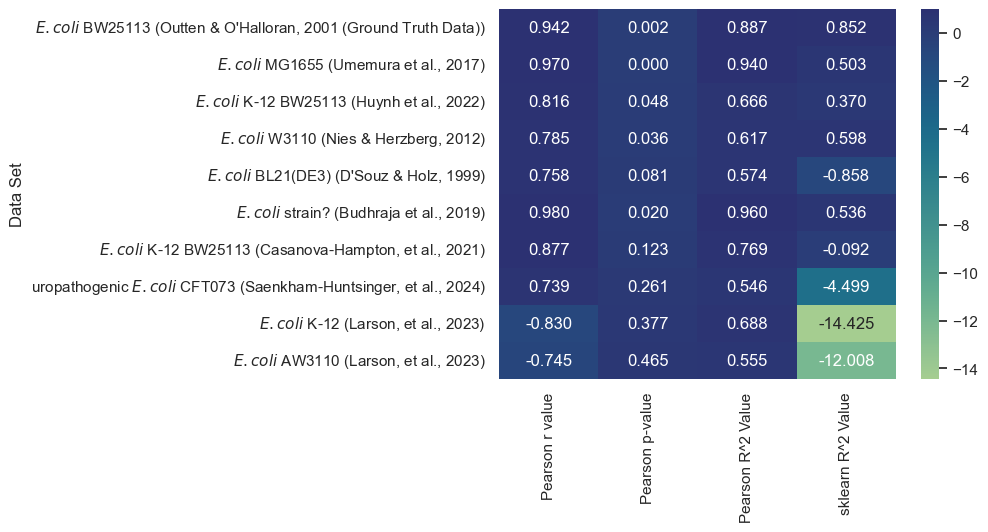

In [17]:
# Make a heatmap of the different correlation values:
LB_correlation_df_ = LB_correlation_df.drop("Elements")
LB_correlation_df_ = LB_correlation_df_.to_pandas()
LB_correlation_df_.set_index("Data Set", inplace=True)
sns.heatmap(LB_correlation_df_, annot=True, fmt=".3f", cmap="crest")

# PLOTS

## Plots with all the data sources (and no special sorting method)

I use these for help with quick visualization of my data. 


Things to consider: 
- maybe add a new font? #sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
- Issue with new fonts is that the italics words remain the old font.

In [18]:
# Custom color palettes (got colors from: https://seaborn.pydata.org/tutorial/color_palettes.html):
custom_palette1 = (sns.color_palette("tab10") + sns.color_palette("husl")[0:1]) # adds coral

custom_palette2 = (sns.color_palette("husl") + sns.color_palette("Set2")[5:6]) # adds yellow
# extra colors if needed: 
# sns.color_palette("husl")[6:7]) # adds light purple
# sns.color_palette("Set2")[5:6]) # adds yellow
# sns.color_palette("Set2")[1:2]) # adds light burnt orange
# sns.color_palette("Set2")[2:3]) # adds light periwinkle
# sns.color_palette("Set2")[6:7]) # adds tan
# sns.color_palette("Paired")[0:1]) # adds light blue

# note: it seems like when no palette is specified, the default is husl and the colors don't repeat at all!

# Marker styles (https://seaborn.pydata.org/tutorial/properties.html, https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers): 
# marker options: ["o", "s", "D", "X", "P", "v", "^", "<", ">", "1", "2", "3", "4", "8", "p", "P", "*", "h", "H", "+", "x", "d", "|", "_"]
# more options: [(4,1,0)), (8,1,0), (8,2,0) ] # (num sides, fill style, angle)

custom_markers1_SGT = [(4,2,45), (4,2,0)] # markers for the simulation and ground truth data
custom_markers1_exp = ["o", "^", "d", (4,0,45), "p", "h", "8", "P", (4,1,0)] # markers for the experimental data

custom_markers2_SGT = ["*", (8,1,0)] # markers for the simulation and ground truth data

custom_markers3_SGT = ["o","P"]
custom_markers3_exp = ["+",(4,2,45), "1", "2", "3", "4", (8,2,0), "x", (4,2,0)]

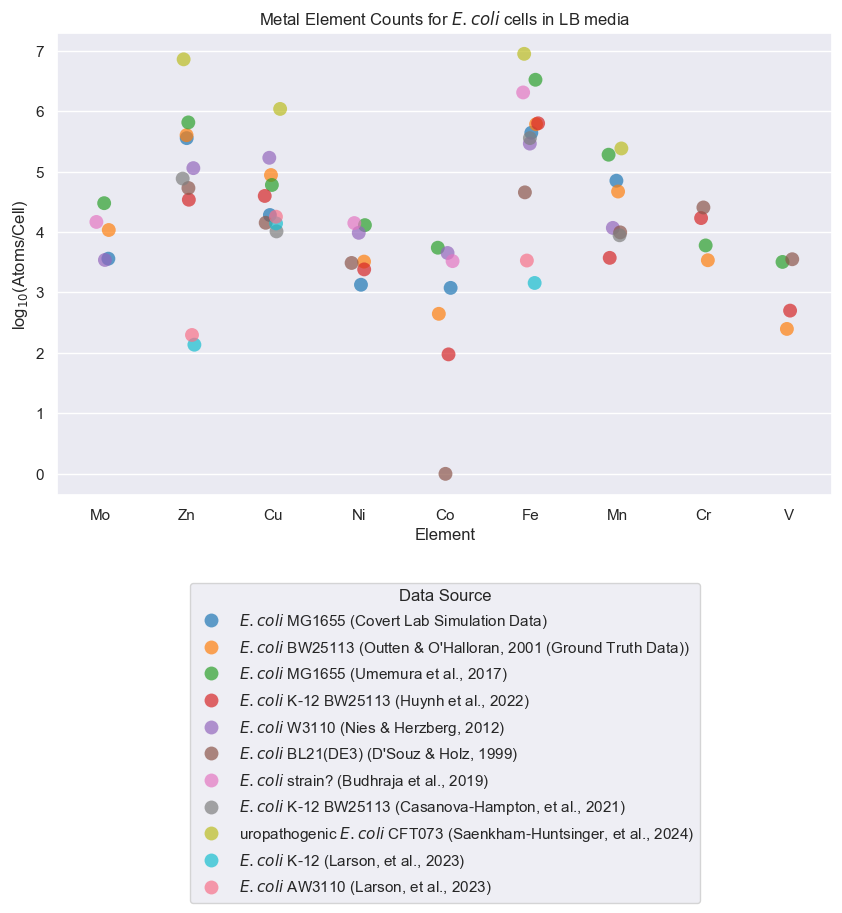

In [19]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))

ax = sns.stripplot(data=df_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=10, alpha=.7, palette=custom_palette1, jitter=True)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB media")
plt.show()

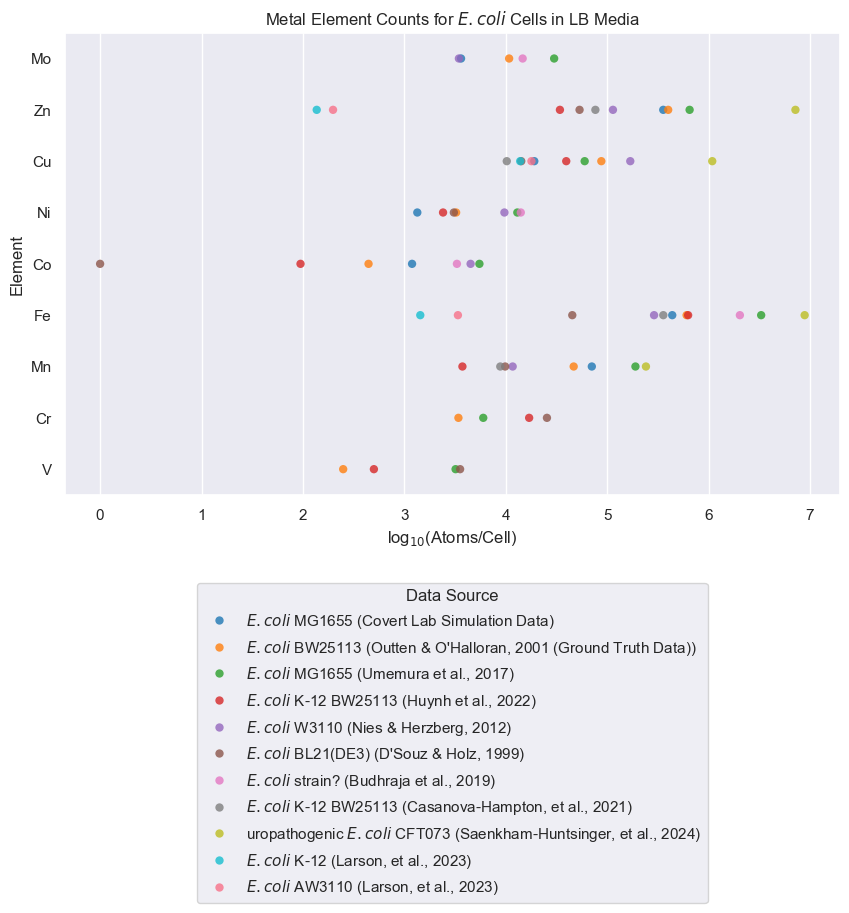

In [20]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", size=6, alpha=.8, palette=custom_palette1, jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

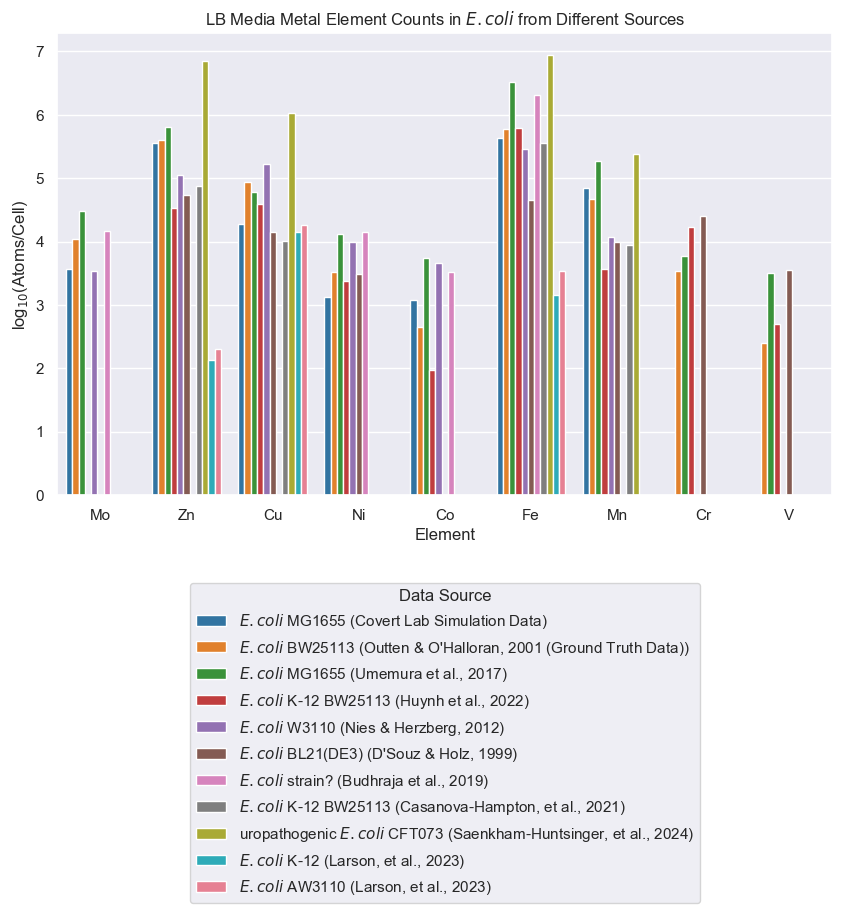

In [21]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_pd, x="Element", y="log$_{10}$(Atoms/Cell)", palette=custom_palette1, hue="Data Source")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("LB Media Metal Element Counts in $\t{E. coli}$ from Different Sources")
plt.show()

# Plot with the median

Obtaining Medians 

Method 1: 
Transpose the data frame and then sort by the median of each column.
(Still have to manually get the mean of each column and then manually tell it to sort by a certain order)

Possible method 2:
Manually calc the median for each element (i.e. each row), and then sort by that column, and finally, drop that column out. Note that polars does not recognize row names, so might need to remove element names before sorting or switch to pandas. 
 

In [22]:
# todo ask cyrus if he knows an easier way to do this with polars and why this code block is darker than everything else?
# Transpose the DF for sorting
lb_exp_dataT = lb_exp_data.drop("Element")
lb_exp_dataT = lb_exp_dataT.transpose(include_header=True, header_name="Source", column_names=lb_exp_data.get_column("Element"))

# calculate the median for each column:
# could also probably use: lb_exp_dataT.select(pl.median("Mo"))
Mo_median = lb_exp_dataT.select("Mo").median()
Zn_median = lb_exp_dataT.select("Zn").median()
Cu_median = lb_exp_dataT.select("Cu").median()
Co_median = lb_exp_dataT.select("Co").median()
Ni_median = lb_exp_dataT.select("Ni").median()
Fe_median = lb_exp_dataT.select("Fe").median()
Mn_median = lb_exp_dataT.select("Mn").median()
Cr_median = lb_exp_dataT.select("Cr").median()
V_median = lb_exp_dataT.select("V").median()

medians = [Mo_median.item(), Zn_median.item(), Cu_median.item(), Ni_median.item(), Co_median.item(), Fe_median.item(), Mn_median.item(), Cr_median.item(), V_median.item()]

# next, have to manually add this back to the original data frame, sort it, then drop the medians column

# create df with medians 
medians_df = pl.DataFrame({
    "Element": ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"],
    "Median": medians})

# join the medians df with the original data frame! 
lb_exp_data_with_medians = lb_exp_data.join(medians_df, on="Element", how="left", coalesce=True)

# sort by the median column
lb_exp_data_sorted_medians = lb_exp_data_with_medians.sort("Median", descending=True)

# drop the median column
lb_exp_data_sorted_medians = lb_exp_data_sorted_medians.drop("Median")

# reshape the data for graphs
df_long_medians = lb_exp_data_sorted_medians.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_medians_pd = df_long_medians.to_pandas()

lb_exp_data_sorted_medians

Element,$ {E. coli}$ MG1655 (Covert Lab Simulation Data),"$ {E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))","$ {E. coli}$ MG1655 (Umemura et al., 2017)","$ {E. coli}$ K-12 BW25113 (Huynh et al., 2022)","$ {E. coli}$ W3110 (Nies & Herzberg, 2012)","$ {E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)","$ {E. coli}$ strain? (Budhraja et al., 2019)","$ {E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)","uropathogenic $ {E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)","$ {E. coli}$ K-12 (Larson, et al., 2023)","$ {E. coli}$ AW3110 (Larson, et al., 2023)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Fe""",5.641744,5.783291,6.518514,5.79822,5.462398,4.656006,6.308642,5.553499,6.947232,3.1572,3.528351
"""Zn""",5.552971,5.601669,5.812913,4.534125,5.056905,4.727724,null,4.883776,6.85639,2.135949,2.296861
"""Cu""",4.281401,4.942388,4.778151,4.596439,5.227887,4.152744,null,4.010005,6.036124,4.142316,4.253392
"""Mn""",4.848615,4.669722,5.278754,3.5727,4.068186,3.99411,null,3.946002,5.382291,null,null
"""Mo""",3.559093,4.033304,4.477121,null,3.537819,null,4.166667,null,null,null,null
"""Cr""",null,3.533308,3.778151,4.230616,null,4.406193,null,null,null,null,null
"""Ni""",3.127828,3.510581,4.113943,3.38171,3.986772,3.488276,4.148148,null,null,null,null
"""V""",null,2.396953,3.50515,2.699801,null,3.549786,null,null,null,null,null
"""Co""",3.076086,2.646951,3.740363,1.976143,3.653213,0.0,3.518519,null,null,null,null


## Basic Median Plots

In [23]:
# todo ask cyrus if he knows an easier way to do this with polars and why this code block is darker than everything else?
# Transpose the DF for sorting
lb_exp_dataT = lb_exp_data.drop("Element")
lb_exp_dataT = lb_exp_dataT.transpose(include_header=True, header_name="Source", column_names=lb_exp_data.get_column("Element"))

# calculate the median for each column:
# could also probably use: lb_exp_dataT.select(pl.median("Mo"))
Mo_median = lb_exp_dataT.select("Mo").median()
Zn_median = lb_exp_dataT.select("Zn").median()
Cu_median = lb_exp_dataT.select("Cu").median()
Co_median = lb_exp_dataT.select("Co").median()
Ni_median = lb_exp_dataT.select("Ni").median()
Fe_median = lb_exp_dataT.select("Fe").median()
Mn_median = lb_exp_dataT.select("Mn").median()
Cr_median = lb_exp_dataT.select("Cr").median()
V_median = lb_exp_dataT.select("V").median()

medians = [Mo_median.item(), Zn_median.item(), Cu_median.item(), Ni_median.item(), Co_median.item(), Fe_median.item(), Mn_median.item(), Cr_median.item(), V_median.item()]

# next, have to manually add this back to the original data frame, sort it, then drop the medians column

# create df with medians 
medians_df = pl.DataFrame({
    "Element": ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"],
    "Median": medians})

# join the medians df with the original data frame! 
lb_exp_data_with_medians = lb_exp_data.join(medians_df, on="Element", how="left", coalesce=True)

# sort by the median column
lb_exp_data_sorted_medians = lb_exp_data_with_medians.sort("Median", descending=True)

# drop the median column
lb_exp_data_sorted_medians = lb_exp_data_sorted_medians.drop("Median")

# reshape the data for graphs
df_long_medians = lb_exp_data_sorted_medians.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_medians_pd = df_long_medians.to_pandas()

lb_exp_data_sorted_medians

Element,$ {E. coli}$ MG1655 (Covert Lab Simulation Data),"$ {E. coli}$ BW25113 (Outten & O'Halloran, 2001 (Ground Truth Data))","$ {E. coli}$ MG1655 (Umemura et al., 2017)","$ {E. coli}$ K-12 BW25113 (Huynh et al., 2022)","$ {E. coli}$ W3110 (Nies & Herzberg, 2012)","$ {E. coli}$ BL21(DE3) (D'Souz & Holz, 1999)","$ {E. coli}$ strain? (Budhraja et al., 2019)","$ {E. coli}$ K-12 BW25113 (Casanova-Hampton, et al., 2021)","uropathogenic $ {E. coli}$ CFT073 (Saenkham-Huntsinger, et al., 2024)","$ {E. coli}$ K-12 (Larson, et al., 2023)","$ {E. coli}$ AW3110 (Larson, et al., 2023)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Fe""",5.641744,5.783291,6.518514,5.79822,5.462398,4.656006,6.308642,5.553499,6.947232,3.1572,3.528351
"""Zn""",5.552971,5.601669,5.812913,4.534125,5.056905,4.727724,null,4.883776,6.85639,2.135949,2.296861
"""Cu""",4.281401,4.942388,4.778151,4.596439,5.227887,4.152744,null,4.010005,6.036124,4.142316,4.253392
"""Mn""",4.848615,4.669722,5.278754,3.5727,4.068186,3.99411,null,3.946002,5.382291,null,null
"""Mo""",3.559093,4.033304,4.477121,null,3.537819,null,4.166667,null,null,null,null
"""Cr""",null,3.533308,3.778151,4.230616,null,4.406193,null,null,null,null,null
"""Ni""",3.127828,3.510581,4.113943,3.38171,3.986772,3.488276,4.148148,null,null,null,null
"""V""",null,2.396953,3.50515,2.699801,null,3.549786,null,null,null,null,null
"""Co""",3.076086,2.646951,3.740363,1.976143,3.653213,0.0,3.518519,null,null,null,null


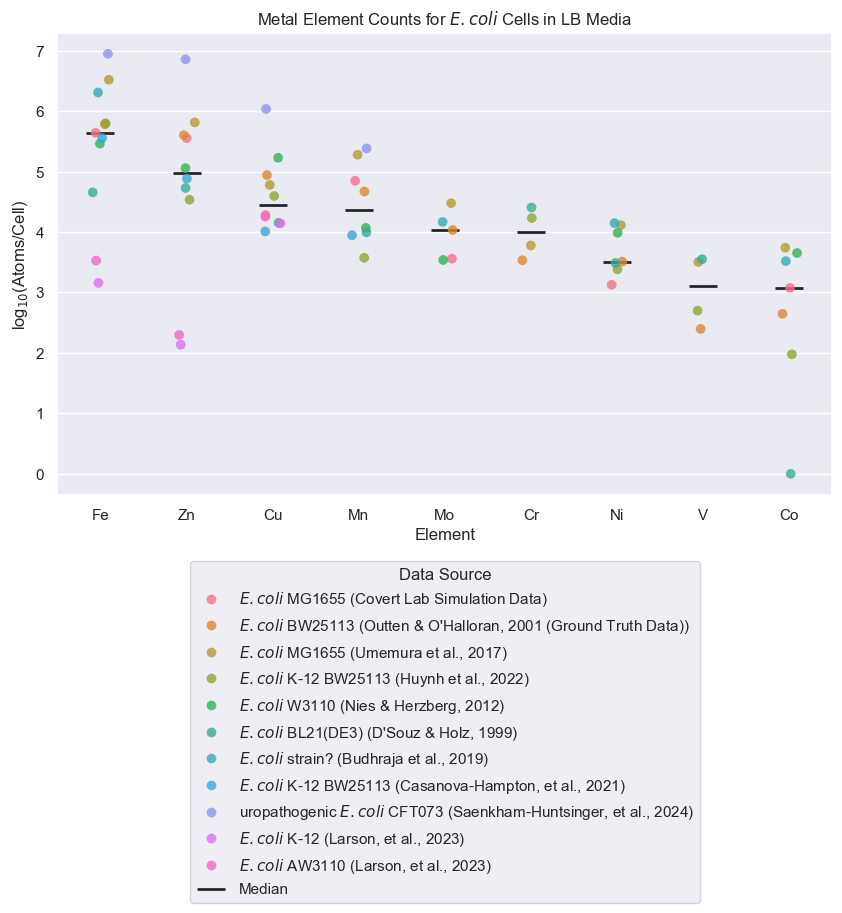

In [24]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=7, alpha=.8, jitter=True)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

# plot the median values for each element:
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
sns.color_palette("tab10")
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

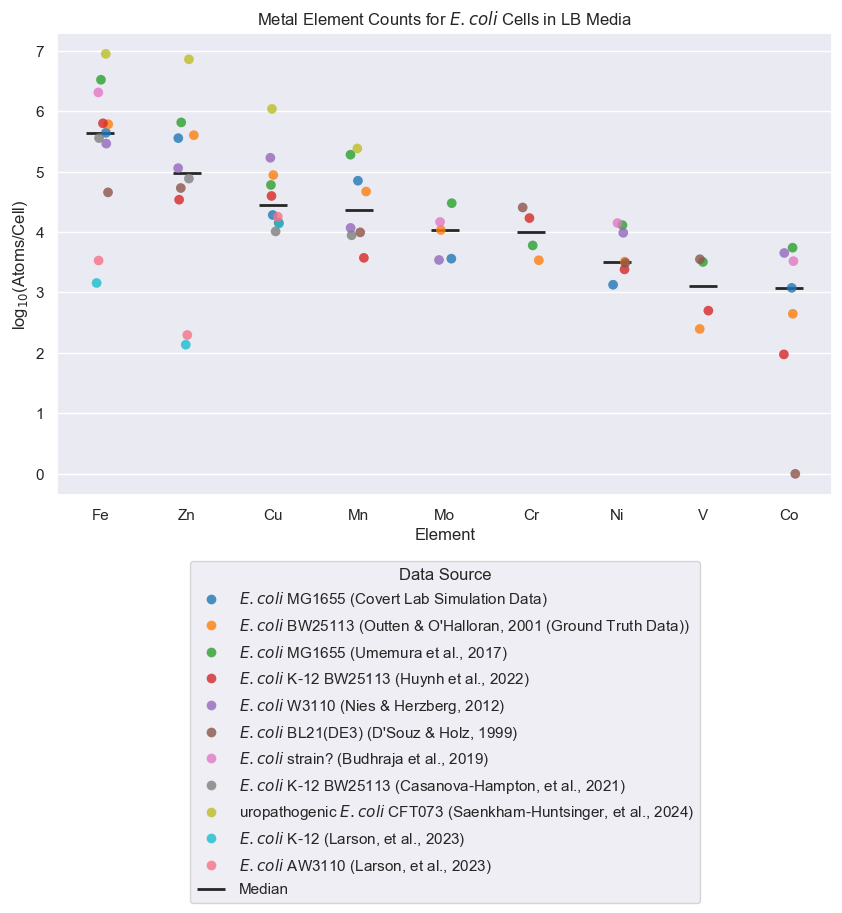

In [25]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=7, alpha=.8, palette=custom_palette1, jitter=True)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

# plot the median values for each element:
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
sns.color_palette("tab10")
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

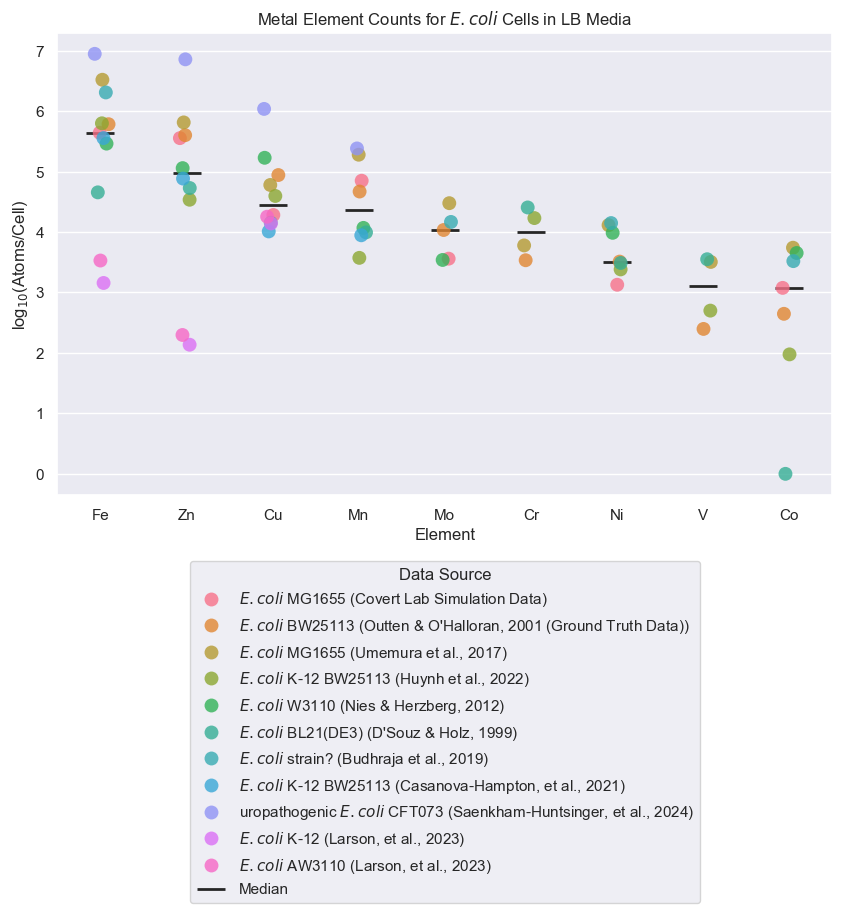

In [26]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", size=10, alpha=.8, jitter=True)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

# plot the median values for each element:
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
sns.color_palette("tab10")
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

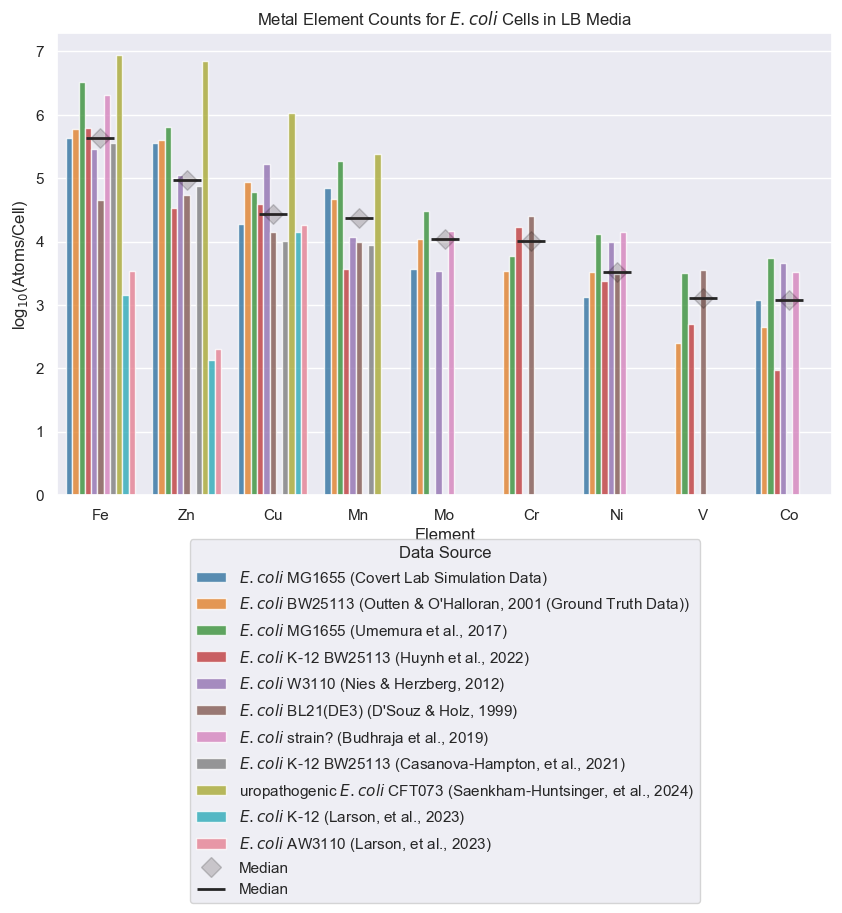

In [27]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# plot all the data:
ax = sns.barplot(data=df_long_medians_pd, x="Element", y="log$_{10}$(Atoms/Cell)", palette=custom_palette1, hue="Data Source", alpha=.8)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()

# plot the median values for each element:
ax = sns.stripplot(data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, palette="dark:red")

# plot the median values for each element:
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

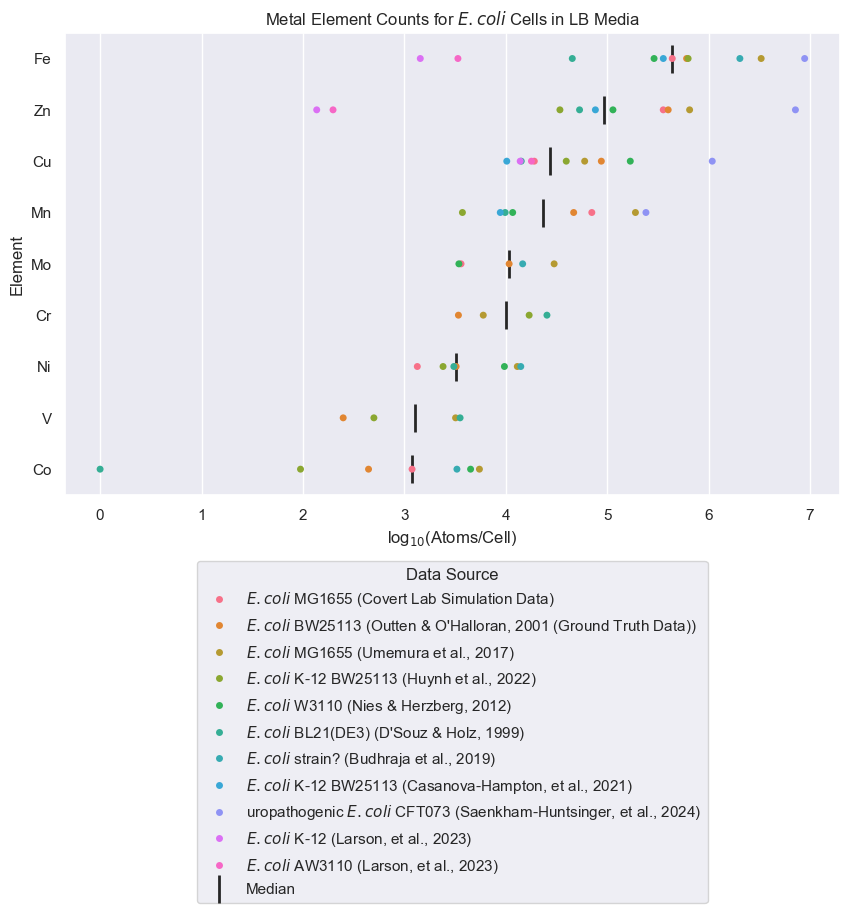

In [28]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
sns.pointplot(
     data=long_medians_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="|", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

## Improve the figure styling:

This link is really helpful: https://seaborn.pydata.org/tutorial/properties.html 

Option #1: Made this to see what it would be like doing all different shades of grey. had trouble visualizing, so I ended up using a green palette instead to improve it a bit.

- I personally do not think this is easy enough to read. Maybe I should also make the Ground Truth and simulation data different?
- It is nice that I am able to make use of the stripplot jitter function, however, the caviat is that I cannot use different markers.

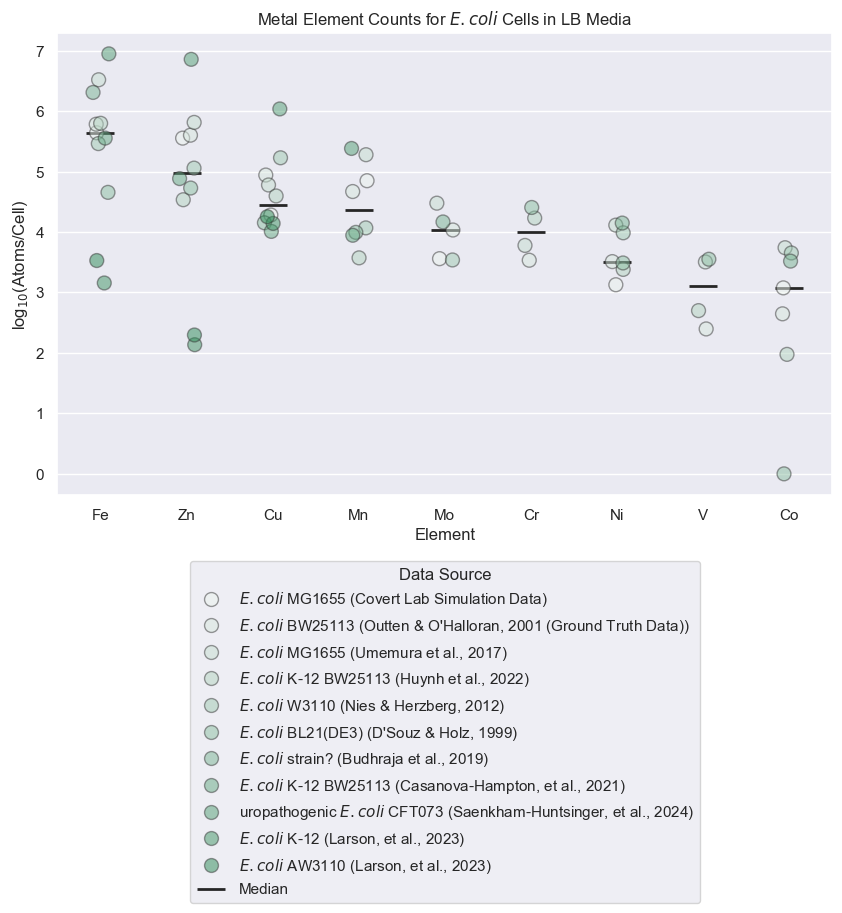

In [29]:
 # Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", palette=sns.light_palette("seagreen", 11), s=10, linewidth=1, alpha=.5) 
# TODO: note that you cannot jitter data when using scatter plots, which I think makes this difficult to see!

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

Option #2: Here is what it would look like with all different shades of grey with different markers. 

- This is a bit better, but I think the markers are too big and it is difficult to see the data points with how similar the colors are to each other 
- cannot use jitter function with scatter plots

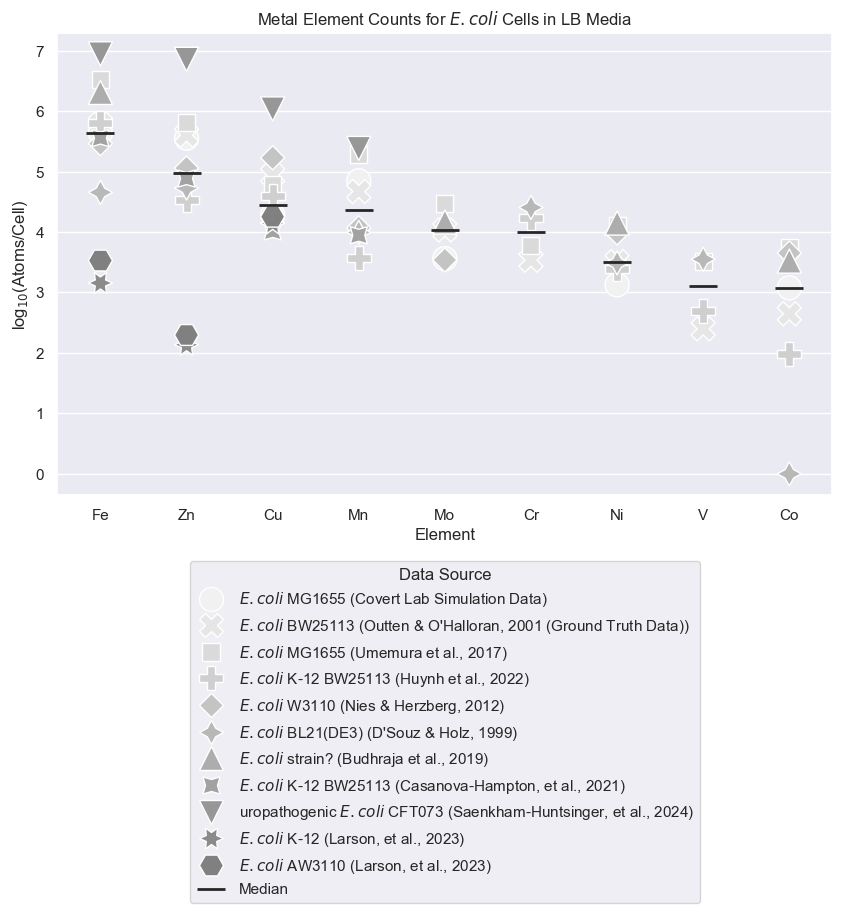

In [30]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=300, palette=sns.light_palette("grey", 11),  linewidth=1,)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')


sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

Option 2.a: Same as 2 but I made the colors of the GT data and sim data different color markers for the GT and sim data
- I think black is still difficult to see, but I think this is a bit better than the white it is above
- you cannot see the difference between the GT and sim data for Zn in this graph becuase I took the linewidth down so far (I think it looks good without line width, but it hides the star)

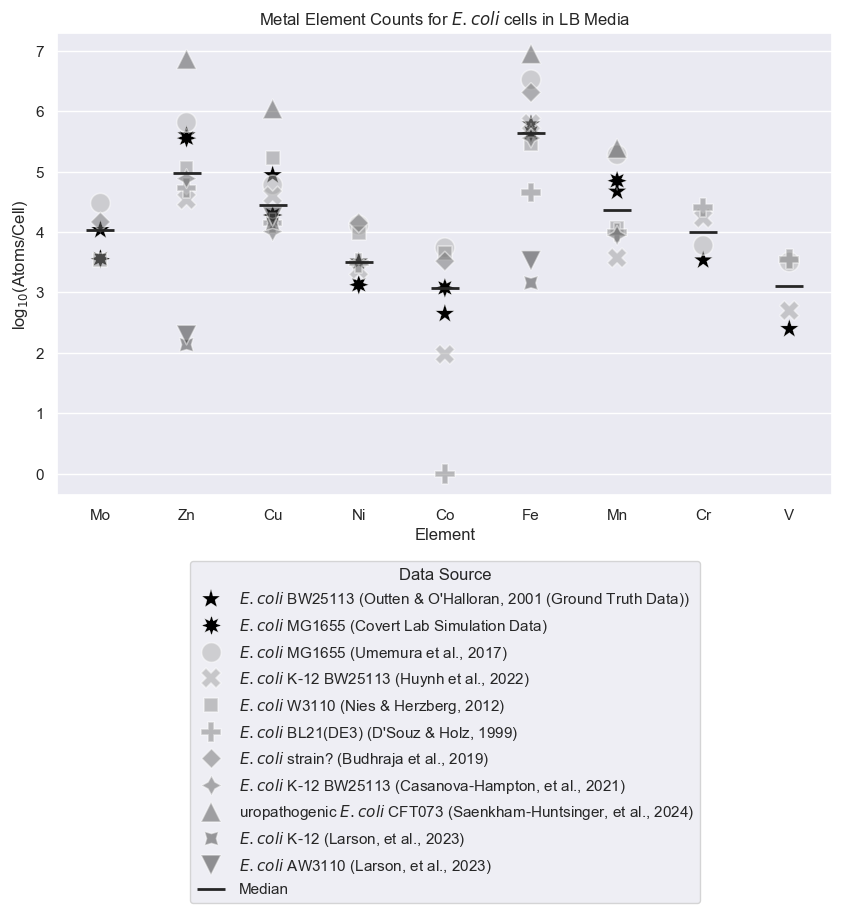

In [31]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# plot the simulation and ground truth data: 
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", s=200, alpha=1, color="000000", markers=custom_markers2_SGT, linewidth=.2) #DC143C

# add a color scale to the other datasets plotted: 
grey_palette = ["#B0B0B0", "#A0A0A0", "#909090", "#808080", "#707070", "#606060", "#505050", "#404040", "#303030"]
ax = sns.scatterplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=200, alpha=.5, palette=grey_palette)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB Media")
plt.show()

Option 2.a.i: same as 2.a but with the first two markers changed to a more sharp style

- I still think this is a bit tough to see what is going on with the data and the greys all look too similar
- I would prefer the appearance of the solid markers to be on the top of all the other data, but I am not sure how to do this with out changing the order of how things are listed on the legend (which might be fine?). In order to do it, I had to manually move the plotting of the solid markers to occur after the rest were plotted.
- should I make the median lines red here?


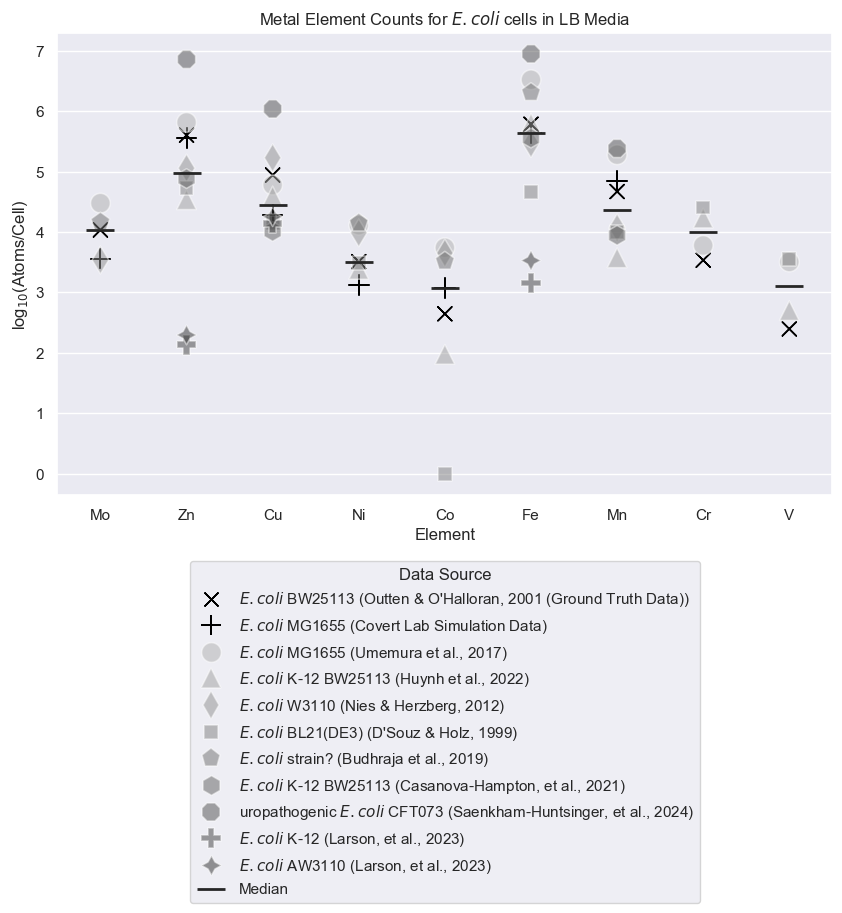

In [32]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# make the plot:
plt.figure(figsize=(10, 6))

# plot the simulation and ground truth data: 
ax = sns.scatterplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", s=200, alpha=1, color="000000", markers=custom_markers1_SGT) #DC143C

# add a color scale to the other datasets plotted: 
grey_palette = ["#B0B0B0", "#A0A0A0", "#909090", "#808080", "#707070", "#606060", "#505050", "#404040", "#303030"]
ax = sns.scatterplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=200, alpha=.5, palette=grey_palette, markers=custom_markers1_exp)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB Media")
plt.show()

Option 2.b: 
- I think red is a bit easier to see, but I think I should try to change to a different marker style

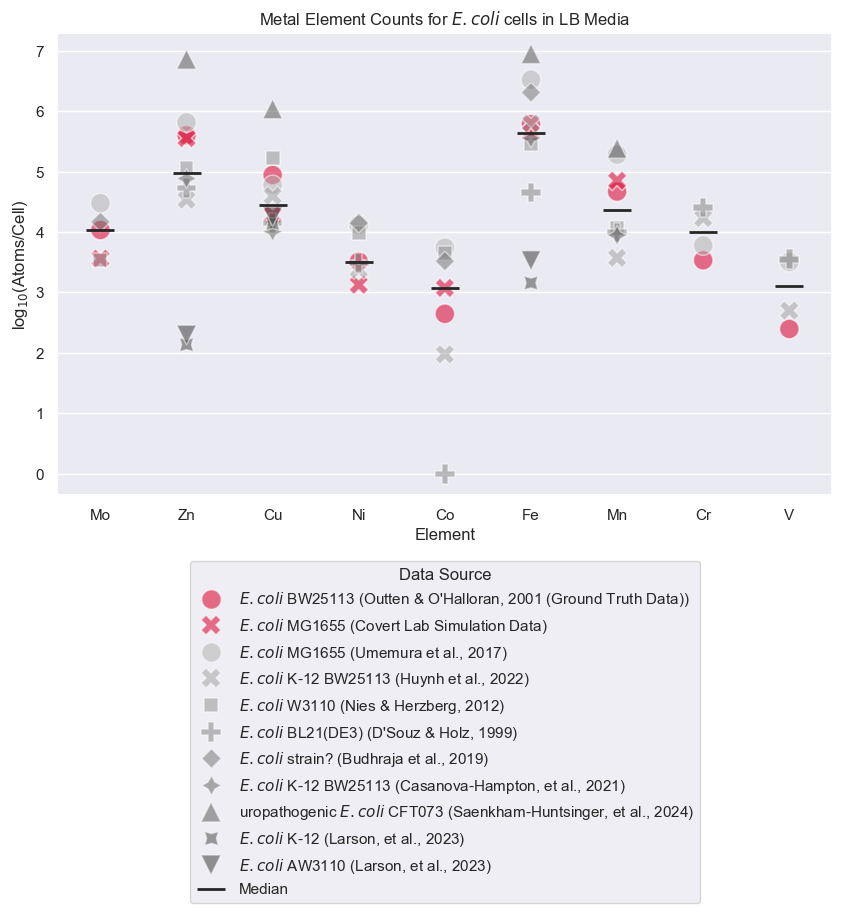

In [33]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# plot the simulation and ground truth data: 
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", s=200, alpha=.6, color="#DC143C") #DC143C

# add a color scale to the other datasets plotted: 
grey_palette = ["#B0B0B0", "#A0A0A0", "#909090", "#808080", "#707070", "#606060", "#505050", "#404040", "#303030"]
ax = sns.scatterplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=200, alpha=.5, palette=grey_palette)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB Media")
plt.show()

Figure 2.b.i: Same as 2.b but with the first two markers changed to a more sharp style


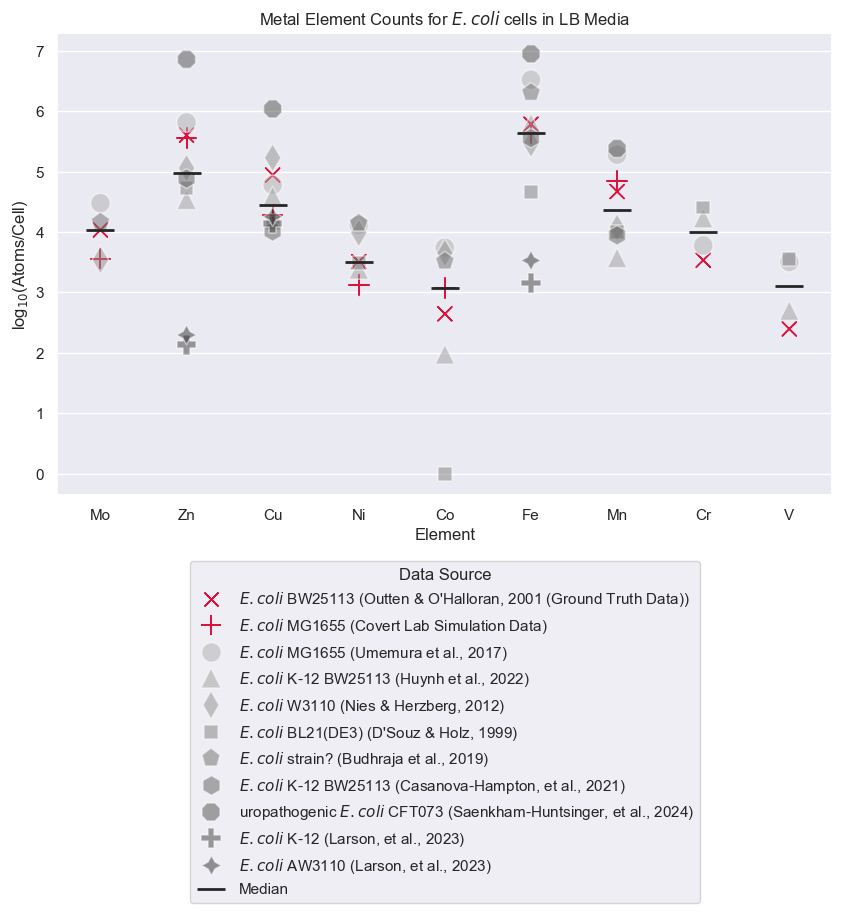

In [34]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# plot the figure
plt.figure(figsize=(10, 6))

# plot the simulation and ground truth data: 
ax = sns.scatterplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", s=200, alpha=1, color="#DC143C", markers=custom_markers1_SGT) #DC143C

# add a color scale to the other datasets plotted: 
grey_palette = ["#B0B0B0", "#A0A0A0", "#909090", "#808080", "#707070", "#606060", "#505050", "#404040", "#303030"]
ax = sns.scatterplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=200, alpha=.5, palette=grey_palette, markers=custom_markers1_exp)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB Media")
plt.show()

Option 2.b.ii: 
- I think this looks nice, however, the colors are not very different from each other and I think the markers are too big. 
- Also, there are not enough different thin shapes to make this one possible 

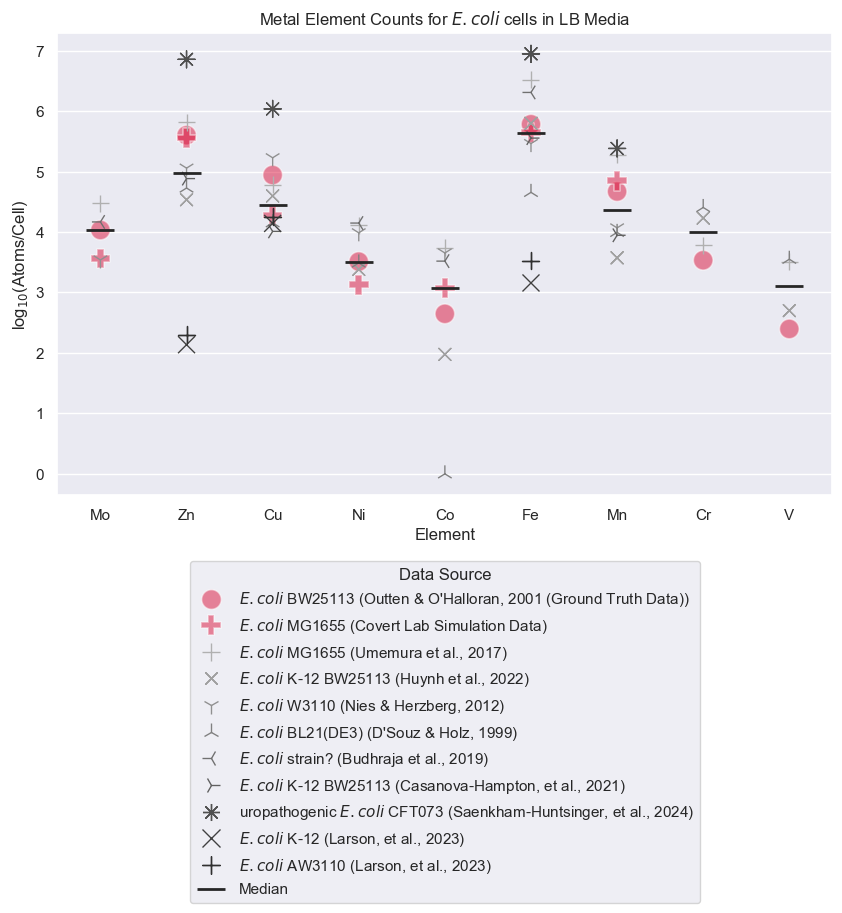

In [35]:
# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# plot the figure
plt.figure(figsize=(10, 6))

# plot the simulation and ground truth data: 
ax = sns.scatterplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", s=200, alpha=.5, color="#DC143C", markers=custom_markers3_SGT) #DC143C

# add a color scale to the other datasets plotted: 
grey_palette = ["#B0B0B0", "#A0A0A0", "#909090", "#808080", "#707070", "#606060", "#505050", "#404040", "#303030"]
ax = sns.scatterplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=150, alpha=1, palette=grey_palette, markers=custom_markers3_exp)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ cells in LB Media")
plt.show()

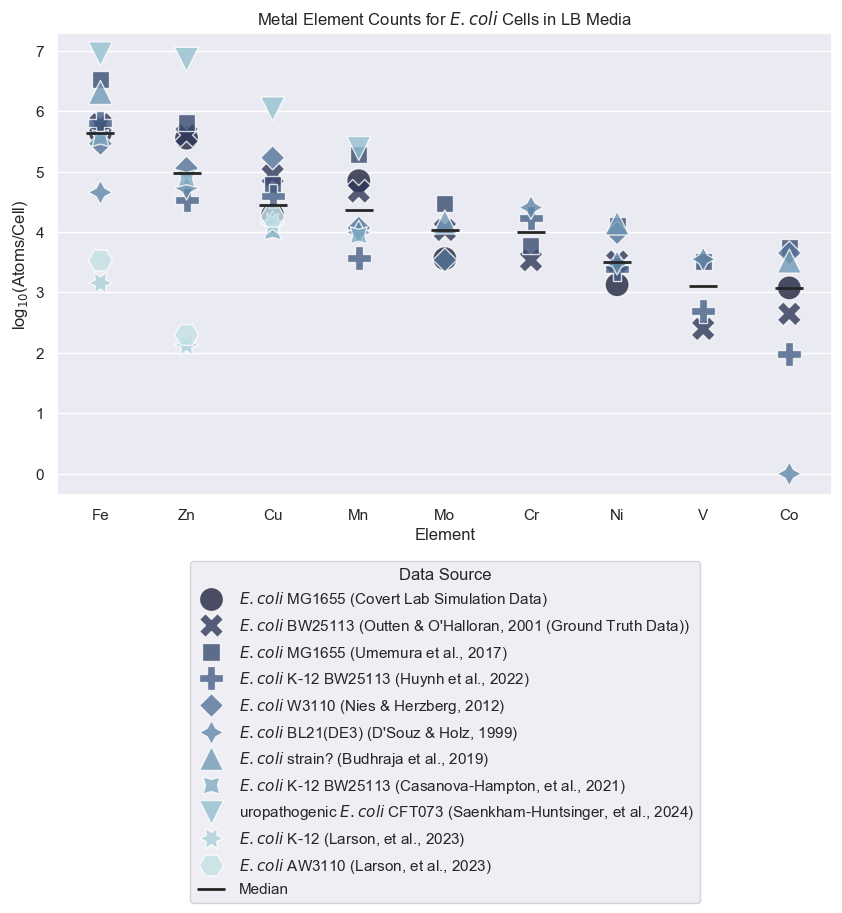

In [36]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", style="Data Source", hue="Data Source", s=300, palette=sns.cubehelix_palette(11, rot=-.2, reverse=True),  linewidth=1, alpha=.8)

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=20, markeredgewidth=2, palette='dark:black')


sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

<Figure size 1000x600 with 0 Axes>

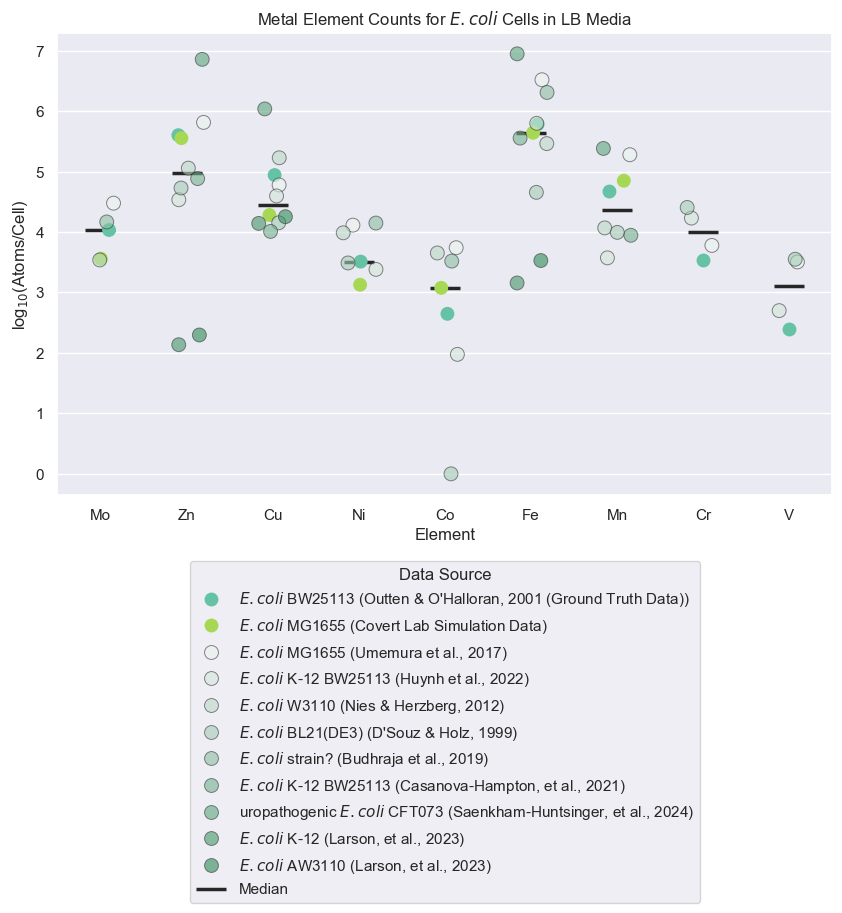

In [37]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))

# split the ground truth and simulation data from the rest of the literature data: 
GT_sim_LB_data = lb_exp_data["Element", '$\t{E. coli}$ BW25113 (Outten & O\'Halloran, 2001 (Ground Truth Data))', "$\t{E. coli}$ MG1655 (Covert Lab Simulation Data)"]
exp_LB_data = lb_exp_data[:,[0,3,4,5,6,7,8,9,10,11]]

GT_sim_LB_data_long = GT_sim_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
GT_sim_LB_data_long_pd = GT_sim_LB_data_long.to_pandas()
exp_LB_data_long = exp_LB_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
exp_LB_data_long_pd = exp_LB_data_long.to_pandas()

# plot the figure
plt.figure(figsize=(10, 6))

custom_palette3 = (sns.color_palette("Set2")[0:1] + sns.color_palette("Set2")[4:5])
original_palette = sns.light_palette("seagreen", 9)

# plot the data: 
ax = sns.stripplot(data=GT_sim_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element",  hue="Data Source", s=10, alpha=1, palette=custom_palette3, jitter=.1) #DC143C
ax = sns.stripplot(data=exp_LB_data_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", palette=original_palette, s=10, linewidth=.7, alpha=.6, jitter=.2) 

# add a small marker at the median value of each element: 
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.pointplot(
     data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", linestyle="none", errorbar=None,
     marker="_", markersize=22, markeredgewidth=2.5, palette='dark:black')

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.9))
plt.title("Metal Element Counts for $\t{E. coli}$ Cells in LB Media")
plt.show()

## template

Media type:  media

Bacterial species:

Units used in calculations:

QUESTIONS/ISSUES: